https://www.pingshiuanchua.com/blog/post/using-youtube-api-to-analyse-youtube-comments-on-python

https://developers.google.com/youtube/v3/docs

https://mp.weixin.qq.com/s?__biz=MzA3OTAxMDQzNQ==&mid=2650634652&idx=1&sn=104cbecc0012c712cdce2e0ab72bd2ab&chksm=87b3d670b0c45f6615d6ac1e0a7e84d91be0ce40d3438fd8ad07c93c60d527ee5fdd58029849&mpshare=1&scene=1&srcid=0624JMdqJbP0ys1upG1tq30M&sharer_sharetime=1592945973355&sharer_shareid=2d100b6ace613eef7480bb415901df3c&exportkey=At1ZMWa1jqV2QNQGaaU%2BcUc%3D&pass_ticket=hNXEM3S%2Bs9yefk1vRE%2FduDaeOI6i9UUJdV4UBrL1mio%3D#rd

https://github.com/stopwords-iso/stopwords-zh/blob/master/stopwords-zh.txt

## Extract YouTube Comments

### Method 1: html

In [1]:
import configparser
from urllib.parse import urlencode
import requests

import time
import json


In [2]:
config = configparser.ConfigParser()
config.read('key.properties')
key = config['google']['python.playground']

**Get Video IDs**

In [3]:
def html_get_videoid(part, maxResults, q, key=key):
    response = requests.get('https://www.googleapis.com/youtube/v3/search?' +
                            urlencode({'part': part,
                                       'maxResults':maxResults,
                                       'q': q,
                                       'key': key}))
    
    search_info = response.json()

    try:
        if response.ok :
            for i in range(maxResults):
                if search_info['items'][i]['snippet']['channelTitle'] == '周杰倫 Jay Chou':
                    video_id = search_info['items'][i]['id']['videoId']
            return video_id
    except IndexError:
        print('Failed to get status, response:', search_info)
        raise

In [4]:
video_id = html_get_videoid(part='snippet', maxResults=5, q='Jay Chou Mojito', key=key)

In [5]:
video_id

'-biOGdYiF-I'

**Get statistics data**

In [6]:
def html_get_statistics_data(video_id, key=key):
    response = requests.get('https://www.googleapis.com/youtube/v3/videos?' +
                            urlencode({'part':'statistics',
                                       'id': video_id,
                                       'key': key}))
    statistics_data = response.json()

    try:
        if response.ok :
            view_count = statistics_data['items'][0]['statistics']['viewCount']
            like_count = statistics_data['items'][0]['statistics']['likeCount']
            dislike_count = statistics_data['items'][0]['statistics']['dislikeCount']
            comment_count = statistics_data['items'][0]['statistics']['commentCount']
            return view_count, like_count, dislike_count, comment_count
    except IndexError:
        print('Failed to get status, response:', statistics_data)
        raise
    
    

In [7]:
view_count, like_count, dislike_count, comment_count = html_get_statistics_data(video_id=video_id, key=key)

In [8]:
print('view_count:', view_count)
print('like_count:', like_count)
print('dislike_count:', dislike_count)
print('comment_count:', comment_count)


view_count: 13808898
like_count: 156013
dislike_count: 6859
comment_count: 15386


**Get comments**

In [9]:
def html_get_comments(part, videoId, key=key):
    time.sleep(1)

    response = requests.get('https://www.googleapis.com/youtube/v3/commentThreads?' +
                        urlencode({'part':part,
                                   'videoId':videoId,
                                   'key': key}))
    resp = response.json()
    resp_tot = resp.copy()
    if 'nextPageToken' in resp:
        page_token = resp['nextPageToken']
        print("resp['nextPageToken']:", resp['nextPageToken'])
        while page_token:
            print('page_token:', page_token)
            response_tk = requests.get('https://www.googleapis.com/youtube/v3/commentThreads?' +
                        urlencode({'part':part,
                                   'pageToken':page_token,
                                   'videoId':videoId,
                                   'key': key}))
            resp_tk = response_tk.json()
            print("len(resp_tk['items']):", len(resp_tk['items']))
            for i in range(len(resp_tk['items'])):
                resp_tot['items'].append(resp_tk['items'][i])
            if 'nextPageToken' in resp_tk:
                page_token = resp_tk['nextPageToken']
                print('page_token:', page_token)
                print('===')
            else:
                break

    return resp_tot


In [10]:
comments_json = html_get_comments(part='snippet', videoId='-biOGdYiF-I', key=key)

resp['nextPageToken']: QURTSl9pMHNLeGp6dXA1SkpuQ0QzcGpCNmd4Vi1CZXVIOEdRSWFQdTVRVk1BQzc4WFdLbkVodXlQU0J6anF1RVoyTHphaFY2U1pqSG5GcU9HbFdIMTdtN3k3MnFXZ00yWW83OElBSk1SM0JwcUNuTlhhM2ctcENhOEFtb216RkI=
page_token: QURTSl9pMHNLeGp6dXA1SkpuQ0QzcGpCNmd4Vi1CZXVIOEdRSWFQdTVRVk1BQzc4WFdLbkVodXlQU0J6anF1RVoyTHphaFY2U1pqSG5GcU9HbFdIMTdtN3k3MnFXZ00yWW83OElBSk1SM0JwcUNuTlhhM2ctcENhOEFtb216RkI=
len(resp_tk['items']): 20
page_token: QURTSl9pMElwR1BxemhSbGliUWwtMG16UG1LeUlhdXRxVzJBa2F1U0NJeF94WWwxMG9ZUjNBWmhFcDZxQmotTFN4Slp2Z0UyNEx2WUpVLWVBMTlIcEtPb2pocVJKeEt3VWdSYVNjV1cxSHMyZlNsTzczckk1R2lqZ21ZYm9tZDFSb0M0M21wLUFCVTk=
===
page_token: QURTSl9pMElwR1BxemhSbGliUWwtMG16UG1LeUlhdXRxVzJBa2F1U0NJeF94WWwxMG9ZUjNBWmhFcDZxQmotTFN4Slp2Z0UyNEx2WUpVLWVBMTlIcEtPb2pocVJKeEt3VWdSYVNjV1cxSHMyZlNsTzczckk1R2lqZ21ZYm9tZDFSb0M0M21wLUFCVTk=
len(resp_tk['items']): 20
page_token: QURTSl9pM2d3dTVYRWx1SkxvdHZHcHY5c1Z6NVJyMlN6ckpwTXVqWkpESlhjd3Z0YmZnSEw3V056ajJHNE9JRE5EV3lsbXY0UTYxLTVMclZWRG9JZE81dm5tZHdWSnVuNFo1NHpNTWF4QUV2OWNUS

len(resp_tk['items']): 20
page_token: QURTSl9pMGFSZE9nb3pwc1pnNWFEVHVpdkRlTnNFN09hTjZhOFpfRUF1YkljYS1VVmFYcHhUdGlvUlhUTWVWTExCN2FCUVlRcXhkOUo1czVBTDE1d3B6MVRjWVhWbFNROUw3QTJieExBUmhvTFJ5WEVIc2RrRjRqNnkzaktTMnFLZk9CMlFTVW1CTlE0bGs=
===
page_token: QURTSl9pMGFSZE9nb3pwc1pnNWFEVHVpdkRlTnNFN09hTjZhOFpfRUF1YkljYS1VVmFYcHhUdGlvUlhUTWVWTExCN2FCUVlRcXhkOUo1czVBTDE1d3B6MVRjWVhWbFNROUw3QTJieExBUmhvTFJ5WEVIc2RrRjRqNnkzaktTMnFLZk9CMlFTVW1CTlE0bGs=
len(resp_tk['items']): 20
page_token: QURTSl9pM2VOeDk2S2J1Vnc4dUNJa3BmYWhTNUs3cGR0b1pmWF9vZXdLWGVuODk4SUlwR3hyWTNOM0hqOHlmM2VuX0pJcWE0dzJQZVpHT1JpRzRTZTVZc3JDWWFUcnh6YTJvM0VCSDFfbUdGODR1TXlIWEZDWExpXzd5alpFMkd6T0l2MG1DeU9xTlBWdVE=
===
page_token: QURTSl9pM2VOeDk2S2J1Vnc4dUNJa3BmYWhTNUs3cGR0b1pmWF9vZXdLWGVuODk4SUlwR3hyWTNOM0hqOHlmM2VuX0pJcWE0dzJQZVpHT1JpRzRTZTVZc3JDWWFUcnh6YTJvM0VCSDFfbUdGODR1TXlIWEZDWExpXzd5alpFMkd6T0l2MG1DeU9xTlBWdVE=
len(resp_tk['items']): 20
page_token: QURTSl9pMjdRRnU1VVM5ZUpQT1ZTbmJRRlc4NE84a2NtN2hJQ3Frc1V0S0djSjFYUmh2cmEtcTVmVElQTT

len(resp_tk['items']): 20
page_token: QURTSl9pMTdOYXpfUkZPbEpZQWloYnh0UlJCbzdkX29uUHhudVVIZm9VcUEyVEVLTXVQVU5rUzA4NTgwbjc5Mi04Y0M2Sm1qNFE3LTliUHZILXh3alVqaHpEMHZYMUNYRjNpdGwwUFY2ZFZRcWZ2eTE4ZFlKSFd1aFZOR3NKVVJfWkN2YkRDQ0lUU1g3LTA=
===
page_token: QURTSl9pMTdOYXpfUkZPbEpZQWloYnh0UlJCbzdkX29uUHhudVVIZm9VcUEyVEVLTXVQVU5rUzA4NTgwbjc5Mi04Y0M2Sm1qNFE3LTliUHZILXh3alVqaHpEMHZYMUNYRjNpdGwwUFY2ZFZRcWZ2eTE4ZFlKSFd1aFZOR3NKVVJfWkN2YkRDQ0lUU1g3LTA=
len(resp_tk['items']): 20
page_token: QURTSl9pM1hyUmxRdTVMWktaejRFVzk5S1ZjTGdhRHRkYXp1TWx2WjZQaXRidnJja0tXRnBHcDhfZEt6U3VYZU41bkhqYjg1ajEyS3NUV0FkMVI5Z1RxTUpHbHR6Qy1PYjg5QVZ2R3lmdi1LeHVCdlIzVkF6ZXBSTmlTOXlWOGg1S25JdjZEUDNFbjJtTlU=
===
page_token: QURTSl9pM1hyUmxRdTVMWktaejRFVzk5S1ZjTGdhRHRkYXp1TWx2WjZQaXRidnJja0tXRnBHcDhfZEt6U3VYZU41bkhqYjg1ajEyS3NUV0FkMVI5Z1RxTUpHbHR6Qy1PYjg5QVZ2R3lmdi1LeHVCdlIzVkF6ZXBSTmlTOXlWOGg1S25JdjZEUDNFbjJtTlU=
len(resp_tk['items']): 20
page_token: QURTSl9pMUtPWXZ6VUdON0dZbFBncVQybUI3U0pWcms0NlEyd3JSSTk1Nzc5dGZwSUZMbVNOcTdoR250Rk

len(resp_tk['items']): 20
page_token: QURTSl9pMDJwaXBLN0dmaHVIZmhGOWhoUURMc1czdTFZZmVKbGc3VUhtLXNCdFF2N0RrdFlONkFNaFRUM0EyelRMSGxpNFRqY1dFMVhPV0Q1Q29Mck1Wb0kwZ085aHoyaFJERHpPUW1HMDZYZFEtV0NpbXVnTG54eUNvS1UxS3lYNDB6aGk5bHdvMVVzYnc=
===
page_token: QURTSl9pMDJwaXBLN0dmaHVIZmhGOWhoUURMc1czdTFZZmVKbGc3VUhtLXNCdFF2N0RrdFlONkFNaFRUM0EyelRMSGxpNFRqY1dFMVhPV0Q1Q29Mck1Wb0kwZ085aHoyaFJERHpPUW1HMDZYZFEtV0NpbXVnTG54eUNvS1UxS3lYNDB6aGk5bHdvMVVzYnc=
len(resp_tk['items']): 20
page_token: QURTSl9pMkZubTZPUGt2QThxODgtdWU1VTFZTWNxMFo4V0czTGpIT05wczN6NHNkVlhJYVhfZklmRXp1N1RTM21aNnNPbmtJMC14SndEallFS0hQSlh2T0NRSHR5b2k3ZnNOV2d5d3NEQWxwUGpCNW1SWUxEeE5qc3lqRjJ6dlNMYm8wSXV5VWcxVnRRNWM=
===
page_token: QURTSl9pMkZubTZPUGt2QThxODgtdWU1VTFZTWNxMFo4V0czTGpIT05wczN6NHNkVlhJYVhfZklmRXp1N1RTM21aNnNPbmtJMC14SndEallFS0hQSlh2T0NRSHR5b2k3ZnNOV2d5d3NEQWxwUGpCNW1SWUxEeE5qc3lqRjJ6dlNMYm8wSXV5VWcxVnRRNWM=
len(resp_tk['items']): 20
page_token: QURTSl9pMTVPajRNaC12QWJfT3Fkb2xlMkZLTExrN0N4cl9aT1VlMFlQeFpSdFVZSVhPYUVwd05pOEJkSG

len(resp_tk['items']): 20
page_token: QURTSl9pM3hhdHBaOF9UM0FPMTlTVThfemh1ZVlFNi1ncGpIWGltUEVFNmVCcW5IYmpaeTFnWENPMU52ZWFkbEpTelQxNGpSMkN4ZDRZX0VWVVdPSXNPSXhOZlg2SWxYSnl1N2gtakd5N3ItV25OV1NBNFVrSzlmVGRtaTdYblQxU01DZy1MY2F5Zk5ETGM=
===
page_token: QURTSl9pM3hhdHBaOF9UM0FPMTlTVThfemh1ZVlFNi1ncGpIWGltUEVFNmVCcW5IYmpaeTFnWENPMU52ZWFkbEpTelQxNGpSMkN4ZDRZX0VWVVdPSXNPSXhOZlg2SWxYSnl1N2gtakd5N3ItV25OV1NBNFVrSzlmVGRtaTdYblQxU01DZy1MY2F5Zk5ETGM=
len(resp_tk['items']): 20
page_token: QURTSl9pMTBYc055LUVCano5b1V5R3BZQzlJb3A5UHdwMXU3ODhULW9NYjY1ZXZuNVA5cUZiYzdWMTRZT1R2UmM3NUVqUlRtakVLcVZ6Tm5EcGJjUG0tUUJfSkhqSkhBVVF0YVFfbVdLQUQ4eE96Yl9UX3UxaWdiamlKRTBneVBCSUI0RXYtSFRsd1JvcmM=
===
page_token: QURTSl9pMTBYc055LUVCano5b1V5R3BZQzlJb3A5UHdwMXU3ODhULW9NYjY1ZXZuNVA5cUZiYzdWMTRZT1R2UmM3NUVqUlRtakVLcVZ6Tm5EcGJjUG0tUUJfSkhqSkhBVVF0YVFfbVdLQUQ4eE96Yl9UX3UxaWdiamlKRTBneVBCSUI0RXYtSFRsd1JvcmM=
len(resp_tk['items']): 20
page_token: QURTSl9pMkdPeTVOemxEMTFhUE81TklTYUhpdi1CVmMtUWdEWjViYVliblUtUEhBWGM5dWdnczV5VmJ2Y3

len(resp_tk['items']): 20
page_token: QURTSl9pMjhkblFvYjlrVlRTOG1BXzVlSVVWbl9URzN2R2xLU3RJeWo3TGlhYy1NT25ZeGVfY1d4dmhwcFg1eEh4OXlIWVZldzlJM3RUWlFncllVZGU0UXQ2MHplNW5qZGs4eDNRZ253bEkyYVZYOGREbThfYWY4Zl84WnpON1RCdWZhajV0WV9VNmZUWFk=
===
page_token: QURTSl9pMjhkblFvYjlrVlRTOG1BXzVlSVVWbl9URzN2R2xLU3RJeWo3TGlhYy1NT25ZeGVfY1d4dmhwcFg1eEh4OXlIWVZldzlJM3RUWlFncllVZGU0UXQ2MHplNW5qZGs4eDNRZ253bEkyYVZYOGREbThfYWY4Zl84WnpON1RCdWZhajV0WV9VNmZUWFk=
len(resp_tk['items']): 20
page_token: QURTSl9pMUJSVmtnVW8wS250djNSbFNZN1lXVjc5cmpNUFBRVkRUNmxVWG9hZThpenB2WF9ySFE1ajVZd1ZpV196WG1yZFhiQXBmcG9Xd1NMVlBPeXZETUdwN2tKUURjOU1IM3M0NF94TFpzX2ZvMU5hYllpQ3VrazB5TGxpSVBuQ0xCdnJ4TlBNVnZzbWs=
===
page_token: QURTSl9pMUJSVmtnVW8wS250djNSbFNZN1lXVjc5cmpNUFBRVkRUNmxVWG9hZThpenB2WF9ySFE1ajVZd1ZpV196WG1yZFhiQXBmcG9Xd1NMVlBPeXZETUdwN2tKUURjOU1IM3M0NF94TFpzX2ZvMU5hYllpQ3VrazB5TGxpSVBuQ0xCdnJ4TlBNVnZzbWs=
len(resp_tk['items']): 20
page_token: QURTSl9pMXh6Y0h4N2lJRmFsRFg5YWtmX1Y4eFBSNUtDeDhxN2t6UGQyMnFCbGdyZUJmSEdpaVd2QmM2Ml

len(resp_tk['items']): 20
page_token: QURTSl9pMmZvRDRaNTVOZWpEQTRYb0xBWmxDeXZ2dUN4N1BaYXU1SnBkclhNNE9xRTM2WHlxR0U2YmVTT0VLQTVERm10UjFtSkZZVGlxSUhBYkhjZDJqckFNMFNwMVUtekFIS0hqRE5TLS0td0s3bzJpdFV2OVRXUEczaWhEUld1b3ZwUXhvMVZEX2hnQ1k=
===
page_token: QURTSl9pMmZvRDRaNTVOZWpEQTRYb0xBWmxDeXZ2dUN4N1BaYXU1SnBkclhNNE9xRTM2WHlxR0U2YmVTT0VLQTVERm10UjFtSkZZVGlxSUhBYkhjZDJqckFNMFNwMVUtekFIS0hqRE5TLS0td0s3bzJpdFV2OVRXUEczaWhEUld1b3ZwUXhvMVZEX2hnQ1k=
len(resp_tk['items']): 20
page_token: QURTSl9pMzcyd3ljZXJkaWdqbkQ1eEU4Rlhmb2lNLW5tTUE2WlVza01RVV9GT0UxNHkxQWoySU9OcFNrMGhZazJKdEZMbXF3V29oS0F4Ylp4TXI4Y2d6bFpySE5kZkFwS1B0OXFnV2kxVDNXNWFWa01NTU9VMjM2bDdDOHBkUDdKVm9mbXZmVkttVlF0Q1E=
===
page_token: QURTSl9pMzcyd3ljZXJkaWdqbkQ1eEU4Rlhmb2lNLW5tTUE2WlVza01RVV9GT0UxNHkxQWoySU9OcFNrMGhZazJKdEZMbXF3V29oS0F4Ylp4TXI4Y2d6bFpySE5kZkFwS1B0OXFnV2kxVDNXNWFWa01NTU9VMjM2bDdDOHBkUDdKVm9mbXZmVkttVlF0Q1E=
len(resp_tk['items']): 20
page_token: QURTSl9pM0dMYVFmUTRneFhEanFnU2R3ejNINFBraF9KVlJsaXZDUTUwaFdEYnlSTEJOS0J4N1QtLUZiQW

len(resp_tk['items']): 20
page_token: QURTSl9pMGtkQVo5bFkwYk5aTjN5QXVob3hKbFlQd21acFN5VHZGVVZORTBDZmkwOVoyTjVxV3hxTG82SWNPYm1KMjA4TnRxWGZjZG1YMUw0bThjYTVMeHpHRUJJSEFqSmV1bDgwT1dlT21Ec1l6aXpteDdYd3JUNUlad0dYSUVaMnhxV0pVWnZjd2xPNXlk
===
page_token: QURTSl9pMGtkQVo5bFkwYk5aTjN5QXVob3hKbFlQd21acFN5VHZGVVZORTBDZmkwOVoyTjVxV3hxTG82SWNPYm1KMjA4TnRxWGZjZG1YMUw0bThjYTVMeHpHRUJJSEFqSmV1bDgwT1dlT21Ec1l6aXpteDdYd3JUNUlad0dYSUVaMnhxV0pVWnZjd2xPNXlk
len(resp_tk['items']): 20
page_token: QURTSl9pMlJaVXhfcVdQR1BfZTZBUGZ3TjM1d2RLc1hwNXhnb3ZzNmw3bEFVQXFSR0I1SUtVUDNuc3lBZWxmbUszd2h0VlNQMDNjRWdySFBpdGF1elI5Y2pTdGJhVXVRYU9sTElfRVF2eldOdktzVmVRc3dzREJEUjlrZDNkaFRaYVc2X05jMzBBbjNaNlN3
===
page_token: QURTSl9pMlJaVXhfcVdQR1BfZTZBUGZ3TjM1d2RLc1hwNXhnb3ZzNmw3bEFVQXFSR0I1SUtVUDNuc3lBZWxmbUszd2h0VlNQMDNjRWdySFBpdGF1elI5Y2pTdGJhVXVRYU9sTElfRVF2eldOdktzVmVRc3dzREJEUjlrZDNkaFRaYVc2X05jMzBBbjNaNlN3
len(resp_tk['items']): 20
page_token: QURTSl9pMkRHVk40MU1Ib0ZsUjhod2xiODhZN3RMRVpBUFlCMk4tWXE4aGp2dnM2bzhJZDRvUGFYdmtxek

len(resp_tk['items']): 20
page_token: QURTSl9pMzZpdnBrbUpYX3FHM0NDRWZBWFZyNzA3ejA0b2hfeTJ0YnpVQ1Q1YTI0NTRYNW1PUmJMVmExMzh3VnNiSVhURWg2NzF5dUZLYUdxLWt1ZS1GYnBzUUJZRVFhOG9mTlNEOFVtckVLRzlrYUxLQlZlTVljZ3VSdm9sN18wX1AwdWtQQ2VULUwyeFZz
===
page_token: QURTSl9pMzZpdnBrbUpYX3FHM0NDRWZBWFZyNzA3ejA0b2hfeTJ0YnpVQ1Q1YTI0NTRYNW1PUmJMVmExMzh3VnNiSVhURWg2NzF5dUZLYUdxLWt1ZS1GYnBzUUJZRVFhOG9mTlNEOFVtckVLRzlrYUxLQlZlTVljZ3VSdm9sN18wX1AwdWtQQ2VULUwyeFZz
len(resp_tk['items']): 20
page_token: QURTSl9pMDJPOURqRzgwUE0xczZSZkRlWmdURGp1SEtTbnFYUDFWb1ROVXh6Ry1QaG5pV1JJeV83ZnphaWxWd2N5Skh0VFJuai02ZlVUanBVOHR4b2tDOFlsSXNDbWJfNmJwcEM2aHRVNkpxNk5jLVpmQXdOMGJ1c3ZiZXNCMzl4eUxTLVlVZFRhdVBmc1gt
===
page_token: QURTSl9pMDJPOURqRzgwUE0xczZSZkRlWmdURGp1SEtTbnFYUDFWb1ROVXh6Ry1QaG5pV1JJeV83ZnphaWxWd2N5Skh0VFJuai02ZlVUanBVOHR4b2tDOFlsSXNDbWJfNmJwcEM2aHRVNkpxNk5jLVpmQXdOMGJ1c3ZiZXNCMzl4eUxTLVlVZFRhdVBmc1gt
len(resp_tk['items']): 20
page_token: QURTSl9pMjJHZDFwTFRVSHRqWE9PdklHc3V5UTg5MXlWaThWWWVBcjF0emFhMV8tYU1hSUJQNUF5QUNYN3

len(resp_tk['items']): 20
page_token: QURTSl9pMUIxVVJSV2dYMmZncHF3eGhhWk9IbGN2WDRhMk1wbTRxNjdLbEJGcGtscFJHSWh4YVlrU1pTWHU5NnFGd19uQk9fVzBYOG1FT3hrOFYzbVlsVE5PWVpoMUtfWUVoT3ZDSTNFXzRKQTM2V3JMM0U3Q3F2MW1oRDFMOEhIN2RzZXJEenJ3Q2NWMUhV
===
page_token: QURTSl9pMUIxVVJSV2dYMmZncHF3eGhhWk9IbGN2WDRhMk1wbTRxNjdLbEJGcGtscFJHSWh4YVlrU1pTWHU5NnFGd19uQk9fVzBYOG1FT3hrOFYzbVlsVE5PWVpoMUtfWUVoT3ZDSTNFXzRKQTM2V3JMM0U3Q3F2MW1oRDFMOEhIN2RzZXJEenJ3Q2NWMUhV
len(resp_tk['items']): 20
page_token: QURTSl9pMTZNZmNWUFljUmNFMF96RFlWYndRdzFFX29CTDRiZkp6aDhVVDhTYXhoNVJvUFRseXJobDlHeVREZEZVTGVhYUJLR3pzM19sZEZuelVZOXdtSmhySl8zS0R3aVFKejQyblIxUzY4XzBhRnlHMTdaWTJ5cXBGbVUteTdSOTcwVTdPY3RVNjl3amct
===
page_token: QURTSl9pMTZNZmNWUFljUmNFMF96RFlWYndRdzFFX29CTDRiZkp6aDhVVDhTYXhoNVJvUFRseXJobDlHeVREZEZVTGVhYUJLR3pzM19sZEZuelVZOXdtSmhySl8zS0R3aVFKejQyblIxUzY4XzBhRnlHMTdaWTJ5cXBGbVUteTdSOTcwVTdPY3RVNjl3amct
len(resp_tk['items']): 20
page_token: QURTSl9pMTFnaWQ3eFNqMVRkaWg1Wi1teTAtdFFlM1VJSlVxMmxya2ZSendBbGV4eHB2cGsxSFEwSWlObz

len(resp_tk['items']): 20
page_token: QURTSl9pMUlWOC1ITW1pN3ZmWFIzbmFwUFV1NXBPNlBoa1JXN2JLaWNldENxV2xGN19mQUl2SzR4VFBxMjRzWm41QWNlZWJ5bkNIaFVUVEJzRmowcjMzcEpXMkMxV211dFh5M2d1N0RId0dvTTdPSUY1LTFDZDdWY1Jybk5KSkRDN1BFQ3dzZ2ticzEya2RR
===
page_token: QURTSl9pMUlWOC1ITW1pN3ZmWFIzbmFwUFV1NXBPNlBoa1JXN2JLaWNldENxV2xGN19mQUl2SzR4VFBxMjRzWm41QWNlZWJ5bkNIaFVUVEJzRmowcjMzcEpXMkMxV211dFh5M2d1N0RId0dvTTdPSUY1LTFDZDdWY1Jybk5KSkRDN1BFQ3dzZ2ticzEya2RR
len(resp_tk['items']): 20
page_token: QURTSl9pMWlJNm5tc1NhUUtFRWZFQXZUaGJRbXM2c0FTVWc4VzZrZTc2bFY3U1Q4d2xYbGgyaFV5LTF4QnBfNlA4X2JkaTRwYlUzU1NzZ2hGb3NJWS1GaEpIM01mR1c5bXpYT1B4RU43cGtGMm9RcGY0emVPbU4tSWhoc3A3N1ZOQm1jakNSSGtPa3pWQjdr
===
page_token: QURTSl9pMWlJNm5tc1NhUUtFRWZFQXZUaGJRbXM2c0FTVWc4VzZrZTc2bFY3U1Q4d2xYbGgyaFV5LTF4QnBfNlA4X2JkaTRwYlUzU1NzZ2hGb3NJWS1GaEpIM01mR1c5bXpYT1B4RU43cGtGMm9RcGY0emVPbU4tSWhoc3A3N1ZOQm1jakNSSGtPa3pWQjdr
len(resp_tk['items']): 20
page_token: QURTSl9pMjBqbFNSM0FFZENrWWpQMGI3cTVFNTBBZGtsbnB1ZEltcU5RcEFSWnVteWtjWm5xX3F3TDYzc0

len(resp_tk['items']): 20
page_token: QURTSl9pMGhYaTktd05BbmlNekhhRWZHM1VyQmFUcGRFS3pIcDNFcEVvQVlSeGo2TTVybk41bF9Ca3dlYXpkbXlNcEVQeXl6OEt6Wk5yakRKMTlRbkZrajRsbmIzd2tVOGZrMVZ6SEllQkJJRGp5cUdqbmlTcXh3c0Q3cDUtN0g3SWhQa2xxeWJSMHJITUNz
===
page_token: QURTSl9pMGhYaTktd05BbmlNekhhRWZHM1VyQmFUcGRFS3pIcDNFcEVvQVlSeGo2TTVybk41bF9Ca3dlYXpkbXlNcEVQeXl6OEt6Wk5yakRKMTlRbkZrajRsbmIzd2tVOGZrMVZ6SEllQkJJRGp5cUdqbmlTcXh3c0Q3cDUtN0g3SWhQa2xxeWJSMHJITUNz
len(resp_tk['items']): 20
page_token: QURTSl9pMEJTNG5RbjFOQ1pyS19aODBQODQzVXpyWG5VVVg3WmRuMUd2cTFGQ3d5UjltZGdoTm1XV3M0S2tST0FPVjR3N28zQ2M0YXQ5QVE1eDVEdjhXWGppT00yV2xFbk5XLW1jQjNIX0dOZkVhSEp1SmxQTW5hMTJNc2ZxYW5QVmdXckJNQ3JYNUtvZURs
===
page_token: QURTSl9pMEJTNG5RbjFOQ1pyS19aODBQODQzVXpyWG5VVVg3WmRuMUd2cTFGQ3d5UjltZGdoTm1XV3M0S2tST0FPVjR3N28zQ2M0YXQ5QVE1eDVEdjhXWGppT00yV2xFbk5XLW1jQjNIX0dOZkVhSEp1SmxQTW5hMTJNc2ZxYW5QVmdXckJNQ3JYNUtvZURs
len(resp_tk['items']): 20
page_token: QURTSl9pMmh5dGktMjd1TmFrSjloSnpmOXRkX3ZKOU1oMzJ0ek15dXpxRzlxQVh5Z0RmbHlNQ0RwbXdBb2

len(resp_tk['items']): 20
page_token: QURTSl9pMm85TzE0NUMzNEtPZWFmcEcwTW5KUkx0Rkh0ZURrdG9tUURTQ3gwS0ttUFRTLWxieHFTcTYtdHZGWTlHNGNfcS11aU02YnVHaUVOWDFPOXA3NDl1NlVBYlp5RzVubkVOeks5TGgzQ2lYNkVvYmNkYUkxSjg2dGFzdzlSWFlBaXdIdDdNek94UGc0
===
page_token: QURTSl9pMm85TzE0NUMzNEtPZWFmcEcwTW5KUkx0Rkh0ZURrdG9tUURTQ3gwS0ttUFRTLWxieHFTcTYtdHZGWTlHNGNfcS11aU02YnVHaUVOWDFPOXA3NDl1NlVBYlp5RzVubkVOeks5TGgzQ2lYNkVvYmNkYUkxSjg2dGFzdzlSWFlBaXdIdDdNek94UGc0
len(resp_tk['items']): 20
page_token: QURTSl9pMGxEOFR1SzBHQWhodmtHVVdyWE5SYW5fUUxOa0xFTVV1S2YtZU9vN2FEYXpFemxZcUZYN2hYemw1aXRBX1dTOFAzUkZVTnhxeTJTUnhPc1dVV25rck5odEhWNGVvRVVvRUNrXzBreVU4ank4OFFJdnh2YU56TUx5LUlUSjdjczhBdlJWcUlwc1J3
===
page_token: QURTSl9pMGxEOFR1SzBHQWhodmtHVVdyWE5SYW5fUUxOa0xFTVV1S2YtZU9vN2FEYXpFemxZcUZYN2hYemw1aXRBX1dTOFAzUkZVTnhxeTJTUnhPc1dVV25rck5odEhWNGVvRVVvRUNrXzBreVU4ank4OFFJdnh2YU56TUx5LUlUSjdjczhBdlJWcUlwc1J3
len(resp_tk['items']): 20
page_token: QURTSl9pMG1ILThnMExmaGVUdVN3UkxqbUVqNzNaMWl2anY3b3ExNDBGOE5aeXlvQ0l1bWFodlRvQ2taYl

len(resp_tk['items']): 20
page_token: QURTSl9pMld2LXltbVFpTXhMakdDUWJLODlBazB3amY2MGd0eFhLcE9EZEZGczY5bW11LVJpRmJVVVBxODFLUmMwbXpCcngzQV92aDE2QXlsclh3Q3FQQUF5UWd2MW1RRWZERDdJVHJyQ05mVTlrakRCNHNYNk9CS2VIVlk0T2RkTkx3SHhXN1dRalg3QW53
===
page_token: QURTSl9pMld2LXltbVFpTXhMakdDUWJLODlBazB3amY2MGd0eFhLcE9EZEZGczY5bW11LVJpRmJVVVBxODFLUmMwbXpCcngzQV92aDE2QXlsclh3Q3FQQUF5UWd2MW1RRWZERDdJVHJyQ05mVTlrakRCNHNYNk9CS2VIVlk0T2RkTkx3SHhXN1dRalg3QW53
len(resp_tk['items']): 20
page_token: QURTSl9pMXRqamczbGQxaEpCcXk4ZmpPN0NxcmFyenpwRzc5SktlUktLOExpWW1PYk9KRFJxTmcwcUtqMFpucG9qVnVQWGN2YmFna1ljaHdWLUFVaGFsU2NXZ0xqTXpQdVViMWIxQzlzOVZFUlRERDdjZWdQOEFhR2xCc3VrRnFnWmd4X2ROY0I3NElSLWZt
===
page_token: QURTSl9pMXRqamczbGQxaEpCcXk4ZmpPN0NxcmFyenpwRzc5SktlUktLOExpWW1PYk9KRFJxTmcwcUtqMFpucG9qVnVQWGN2YmFna1ljaHdWLUFVaGFsU2NXZ0xqTXpQdVViMWIxQzlzOVZFUlRERDdjZWdQOEFhR2xCc3VrRnFnWmd4X2ROY0I3NElSLWZt
len(resp_tk['items']): 20
page_token: QURTSl9pMlJORVRmUmxCNHFBQUJTcGxndDdwb1hWNHVUMUw3OUVwRldsdzBfNWZCNGNRU0JMUGF6SWtia2

len(resp_tk['items']): 20
page_token: QURTSl9pMmQ3NE5YME1VOTBqWS1GeC0yOHZXSHdUa19XaW11VzAxUzhGYkdaaTZYbFU5RVR3QkszRTJMMDA4N3dyb01zbWxrcUQ0MGdzREdpemVXYlZhVGNqdzg3S3B5Sy1iNEtkT0xoTEQxRUxnbW1ETnFTck9mcktoOVZMVTBKT0pSR0s2V21JbTFXRUNZ
===
page_token: QURTSl9pMmQ3NE5YME1VOTBqWS1GeC0yOHZXSHdUa19XaW11VzAxUzhGYkdaaTZYbFU5RVR3QkszRTJMMDA4N3dyb01zbWxrcUQ0MGdzREdpemVXYlZhVGNqdzg3S3B5Sy1iNEtkT0xoTEQxRUxnbW1ETnFTck9mcktoOVZMVTBKT0pSR0s2V21JbTFXRUNZ
len(resp_tk['items']): 20
page_token: QURTSl9pM3h3bC14dUpncEMyNkdzbXQ1aXE1MnJLX2VrbG5PN1oyUVROU2R3c0h1S2V3cGdmalMyQU81bmQtSERBWkRWSndKTmpoX3hqR0JuNDZLRU9ZVlo3bGdnSWtUQ2tKZXZ6TERjSmNyMG1qWG5HaHlSZG15YTMwbml6THF5SDZSajktOXpUNEVXNWZU
===
page_token: QURTSl9pM3h3bC14dUpncEMyNkdzbXQ1aXE1MnJLX2VrbG5PN1oyUVROU2R3c0h1S2V3cGdmalMyQU81bmQtSERBWkRWSndKTmpoX3hqR0JuNDZLRU9ZVlo3bGdnSWtUQ2tKZXZ6TERjSmNyMG1qWG5HaHlSZG15YTMwbml6THF5SDZSajktOXpUNEVXNWZU
len(resp_tk['items']): 20
page_token: QURTSl9pMklfczlaZUhEcW9BeGVRYTNFOWRxd09aZ2FoSHpwSXdEYnV2RkZKcUQ3cGdZa09qLWpIMHcwSz

len(resp_tk['items']): 20
page_token: QURTSl9pMTlTeFNkSEE4RzZHZGNUNnFwZ2xKa2I4VkVOWlRMRm9SX0dEQjJzdkZxWENkcGltOTlEVW1RVlNUTkM3NlJoSDBUdW5sZ2Rma3h6aTB4WlByME53V0szMThyX1dBODhYV1hHaE9OUGFnV3FRdnBWYlN4VEVSM3VnV1dZRW1DWXJnUDZUdlItek9G
===
page_token: QURTSl9pMTlTeFNkSEE4RzZHZGNUNnFwZ2xKa2I4VkVOWlRMRm9SX0dEQjJzdkZxWENkcGltOTlEVW1RVlNUTkM3NlJoSDBUdW5sZ2Rma3h6aTB4WlByME53V0szMThyX1dBODhYV1hHaE9OUGFnV3FRdnBWYlN4VEVSM3VnV1dZRW1DWXJnUDZUdlItek9G
len(resp_tk['items']): 20
page_token: QURTSl9pM3lpVHRTMjU3U01tSE4tOXcybk1QbXNvSl9sdkhLZjZlUWlGLUhPeVNPTFlubmxvS3JaY2dJU3NkOGZHeGhQSGZHS2ZaVzF1bENXUTNRX1lrWDQ5emhIaGlUZzF0bFNsdFFzVFRWbUVmNUVUdHRCQW1sZ3djVjlTS0IzMXh5RHdELXpkUC0xdG83
===
page_token: QURTSl9pM3lpVHRTMjU3U01tSE4tOXcybk1QbXNvSl9sdkhLZjZlUWlGLUhPeVNPTFlubmxvS3JaY2dJU3NkOGZHeGhQSGZHS2ZaVzF1bENXUTNRX1lrWDQ5emhIaGlUZzF0bFNsdFFzVFRWbUVmNUVUdHRCQW1sZ3djVjlTS0IzMXh5RHdELXpkUC0xdG83
len(resp_tk['items']): 20
page_token: QURTSl9pMGJFZVU4YmlMcE0zN0tEVlVlSXRKcHZyOXB5OHBXSW9NR1VNeVowNWpfeGdqTU1wcEt6LVE4bX

len(resp_tk['items']): 20
page_token: QURTSl9pMVA3OE9JMloySEdBd2htbVRkMW5Ob0RuVzJ1dmFCXzZsUXJCa1dlY2RMa3doTWdTWklpVVYtUGxyTlhoZUFTWEtYVmtkbnNRWXVDLUZnR0hDQ2t5bTQzNVZwR2lxbnVadUVBcE9hczUwbC0wXzJVY0Z2bTA5VnpsSmNQUnA4eno0TmRLeV9nZ2c5
===
page_token: QURTSl9pMVA3OE9JMloySEdBd2htbVRkMW5Ob0RuVzJ1dmFCXzZsUXJCa1dlY2RMa3doTWdTWklpVVYtUGxyTlhoZUFTWEtYVmtkbnNRWXVDLUZnR0hDQ2t5bTQzNVZwR2lxbnVadUVBcE9hczUwbC0wXzJVY0Z2bTA5VnpsSmNQUnA4eno0TmRLeV9nZ2c5
len(resp_tk['items']): 20
page_token: QURTSl9pMVlVUE0wS0RyaFBQQVRnVkxzQ1hkLW91OThhY0dzN0NMWmhYT2hLejlVUllOMHpQWDd1c1V4VjYtT3VXMXVqS1RPZDI1ODBzS0w2aHMtbXRrNDluSnlvRVRKRnV3R3FGQzc2Q0JTbF95bkh3M3haUm9XQXNfblJLOHp4WGhKOFhGUE1nQ1hPQnY5
===
page_token: QURTSl9pMVlVUE0wS0RyaFBQQVRnVkxzQ1hkLW91OThhY0dzN0NMWmhYT2hLejlVUllOMHpQWDd1c1V4VjYtT3VXMXVqS1RPZDI1ODBzS0w2aHMtbXRrNDluSnlvRVRKRnV3R3FGQzc2Q0JTbF95bkh3M3haUm9XQXNfblJLOHp4WGhKOFhGUE1nQ1hPQnY5
len(resp_tk['items']): 20
page_token: QURTSl9pMVVlY0lFZlVSMlFJVWtwWWxkakJNM0t6NVk1WG8xSnUxNlh4cjNCUU9kX3VwMUVURlNyaktBSV

len(resp_tk['items']): 20
page_token: QURTSl9pMWFyVGFOdmNpazJfdTlId3pNNUtaZFRvRkpBc25QSktuLVhEWG1CYmtjdzBiWDBCdTg0Q3FSZVE5ai1OSUlZbkFkUHVhenJyYnZhbFpldEtwZnp5d2I1cWVSbW1PWVlaNlA2MGFDNW1BTy1nemZCbGJtQ3pwaXQ4Wm5PQVBUbEtXMWJMQ0FLOWR4
===
page_token: QURTSl9pMWFyVGFOdmNpazJfdTlId3pNNUtaZFRvRkpBc25QSktuLVhEWG1CYmtjdzBiWDBCdTg0Q3FSZVE5ai1OSUlZbkFkUHVhenJyYnZhbFpldEtwZnp5d2I1cWVSbW1PWVlaNlA2MGFDNW1BTy1nemZCbGJtQ3pwaXQ4Wm5PQVBUbEtXMWJMQ0FLOWR4
len(resp_tk['items']): 20
page_token: QURTSl9pMGU2NVlfSkdXNFdTUEJ2N2dZUjZMbWxhVFdIZXVOU19DMllVWG0yVEVzM043SGE2NGZzZkhoZnY2VVRqNVZzNkgtbWQ4bHRlQm9hOXV0d1pscWxKLWs2R2tGbDdBR3FNUEFTLTZfSFVxaTFYam0zWnlXQUh0dGxPQ0gtY2NBSmlQaUhzLWJzQkdh
===
page_token: QURTSl9pMGU2NVlfSkdXNFdTUEJ2N2dZUjZMbWxhVFdIZXVOU19DMllVWG0yVEVzM043SGE2NGZzZkhoZnY2VVRqNVZzNkgtbWQ4bHRlQm9hOXV0d1pscWxKLWs2R2tGbDdBR3FNUEFTLTZfSFVxaTFYam0zWnlXQUh0dGxPQ0gtY2NBSmlQaUhzLWJzQkdh
len(resp_tk['items']): 20
page_token: QURTSl9pMy11NmxDVFdMZ2ctV3FaY21Dbl9Qa3hlRXNZYkhaSVFzczVIYUJhSHZPeE1lRE1fU3NvaUIyY2

len(resp_tk['items']): 20
page_token: QURTSl9pMTM1Z3hzQjVtWldnNGlYRjRwc0xmdlg3QUFPU2Njdkk2OXZkaEIzdm4yQXhvVlVCNjRNWTVUdFhjNGhueTJocFh0UkNSTFZNRmQ2VC1yc3ByVVhMQ01jY3NtcU9MOUY0MlRCc1VESjBIT3J2Sm5KV1ZWNHNDV25WT2FXUW9wZHIwNFAtMVRzYUNu
===
page_token: QURTSl9pMTM1Z3hzQjVtWldnNGlYRjRwc0xmdlg3QUFPU2Njdkk2OXZkaEIzdm4yQXhvVlVCNjRNWTVUdFhjNGhueTJocFh0UkNSTFZNRmQ2VC1yc3ByVVhMQ01jY3NtcU9MOUY0MlRCc1VESjBIT3J2Sm5KV1ZWNHNDV25WT2FXUW9wZHIwNFAtMVRzYUNu
len(resp_tk['items']): 20
page_token: QURTSl9pMmZZaFhLeGVjUEstWGFqWHlTcFdRUG12VWRaWEdvbTV1VmxON0FDRVdpTk8zcTJMR3lRUW9jU3RkVzNQUTd5ZExEZVJtcXU0cFpoX0RTVk5LWXBfa0Z6c0t5UWZzR2E0T1l5QV80Q0xPTnAxd0s2WHZScXc0cGgyMGFuRkVMbmp3d25ySVp0a2da
===
page_token: QURTSl9pMmZZaFhLeGVjUEstWGFqWHlTcFdRUG12VWRaWEdvbTV1VmxON0FDRVdpTk8zcTJMR3lRUW9jU3RkVzNQUTd5ZExEZVJtcXU0cFpoX0RTVk5LWXBfa0Z6c0t5UWZzR2E0T1l5QV80Q0xPTnAxd0s2WHZScXc0cGgyMGFuRkVMbmp3d25ySVp0a2da
len(resp_tk['items']): 20
page_token: QURTSl9pMjJfNUM0Q1dra2JsOFZCeFVWWFl1MTVDbFNYRXh5ODh3RVQ4WEIyLVpmT1dNLTFKZE16U2piS1

len(resp_tk['items']): 20
page_token: QURTSl9pMnJZNFF2N2hQbm1OWTNXWE9MRkIwcVgteW9KX0FlUUQ2NFpKM0NfX0l0YXZ3QjhhUjlUQ1Vna0NNZGt5YUwtUnhpakxleUxabnBGa3o1RWlZQkc2YldhdHZEd1NDLV9aMW1lSUo1djdxMllHd3g1MFpCbVBvSVdfM3JZeW1jdDRFU1RnOE9hSW5w
===
page_token: QURTSl9pMnJZNFF2N2hQbm1OWTNXWE9MRkIwcVgteW9KX0FlUUQ2NFpKM0NfX0l0YXZ3QjhhUjlUQ1Vna0NNZGt5YUwtUnhpakxleUxabnBGa3o1RWlZQkc2YldhdHZEd1NDLV9aMW1lSUo1djdxMllHd3g1MFpCbVBvSVdfM3JZeW1jdDRFU1RnOE9hSW5w
len(resp_tk['items']): 20
page_token: QURTSl9pMTFHNzVySjBoRFJxUlI2cEwwcU1aN0p5WmlqdFcwanNpQ1BJTGc3cXA4WVZ4TUdpUmo1ekFqVVdnNTd5MHA2Rmw4WjJkWkVWTjRzMzJvbWdFQlczOFZkaF9lM0VRN0dzWk5oWDdmWW5IX216aEIxRnBNZ0xUanRkVXhQa1lILTQyY285eWpkZ3oz
===
page_token: QURTSl9pMTFHNzVySjBoRFJxUlI2cEwwcU1aN0p5WmlqdFcwanNpQ1BJTGc3cXA4WVZ4TUdpUmo1ekFqVVdnNTd5MHA2Rmw4WjJkWkVWTjRzMzJvbWdFQlczOFZkaF9lM0VRN0dzWk5oWDdmWW5IX216aEIxRnBNZ0xUanRkVXhQa1lILTQyY285eWpkZ3oz
len(resp_tk['items']): 20
page_token: QURTSl9pMkpObHVxYUdYMnVIRmlXWmVJLW1iVm50ZXJKRUxxYnRnV1lMMWRBVHdZOWhoT0dZd1Y4S1ZLcE

len(resp_tk['items']): 20
page_token: QURTSl9pMENyNzhGVlRHNGZtLUwyNFNMMGluYU83SDJJd2ZGMzdhMXRZem96Zkd4eFdyNzJOcXZlZERDUlllbTBtcGRhbXlWbGhvcmlFVU9kZjhaMHhXNVRqcndSeVB5SEdhWE03cFNCdi05V1p5V0tDTWp3ZXQwcEczZW1IUEdwM0hDcnYyR1NxMTBBakxs
===
page_token: QURTSl9pMENyNzhGVlRHNGZtLUwyNFNMMGluYU83SDJJd2ZGMzdhMXRZem96Zkd4eFdyNzJOcXZlZERDUlllbTBtcGRhbXlWbGhvcmlFVU9kZjhaMHhXNVRqcndSeVB5SEdhWE03cFNCdi05V1p5V0tDTWp3ZXQwcEczZW1IUEdwM0hDcnYyR1NxMTBBakxs
len(resp_tk['items']): 20
page_token: QURTSl9pMmpMc2QtLXZnRW15QmJFVHpIaWJRcmZFM19UbkNrbTQxV2RRdlJrRUNob08xbDlyMnFYVUlKQnAxYlN5Y0thQWpDaWl3ZmdaLW5ZQ0pPdUJFaThXcFJrRWxfZkhuQkRlSk5zaFM2c3BYcU50andZekNOS3ZmVGhKMTZiRTQtdkFHUDJyeWhkZEMz
===
page_token: QURTSl9pMmpMc2QtLXZnRW15QmJFVHpIaWJRcmZFM19UbkNrbTQxV2RRdlJrRUNob08xbDlyMnFYVUlKQnAxYlN5Y0thQWpDaWl3ZmdaLW5ZQ0pPdUJFaThXcFJrRWxfZkhuQkRlSk5zaFM2c3BYcU50andZekNOS3ZmVGhKMTZiRTQtdkFHUDJyeWhkZEMz
len(resp_tk['items']): 20
page_token: QURTSl9pMXlkYWliUzQxZlRZTXJBMUxEMEllN1loQXNQR19xX1lxRU9NTFJoVlJ6MGdWX1lRckkzSWVUWU

len(resp_tk['items']): 20
page_token: QURTSl9pM0J1Tm1odXlvcER1ZkJiakozWFpaSklKWmVTcmd2V3pnbnByYlllVDR4VTR2bkFoWVNzbkM0bGlhbFRsdnMtQ2lKUXZseEFLb2xqalZfd2V2U0JjNmtBS3AwYWpyeF90aUwxQkxkYkJYcnhIdkE2cTdUSDhMWmdSallVYTBLUUpSN1dNZnlEVmgw
===
page_token: QURTSl9pM0J1Tm1odXlvcER1ZkJiakozWFpaSklKWmVTcmd2V3pnbnByYlllVDR4VTR2bkFoWVNzbkM0bGlhbFRsdnMtQ2lKUXZseEFLb2xqalZfd2V2U0JjNmtBS3AwYWpyeF90aUwxQkxkYkJYcnhIdkE2cTdUSDhMWmdSallVYTBLUUpSN1dNZnlEVmgw
len(resp_tk['items']): 20
page_token: QURTSl9pMnZ1bHZ4VnBTRUxqcWNPbVpWTFZQZDkyTzhteTM0UmhpMGN3Qlk5cmFqclFaNjhtendBTTNqaFdrNWM0RVhtT0ZOU2pXOGV4TW53eU5BWkdvdlhzRW5sZDN2aDMxV1pwNXpXWGo2S3Q0U2RQbTRQdkE1WEpUUk1id2FzcHY4LVE2clFHZVo4dmxG
===
page_token: QURTSl9pMnZ1bHZ4VnBTRUxqcWNPbVpWTFZQZDkyTzhteTM0UmhpMGN3Qlk5cmFqclFaNjhtendBTTNqaFdrNWM0RVhtT0ZOU2pXOGV4TW53eU5BWkdvdlhzRW5sZDN2aDMxV1pwNXpXWGo2S3Q0U2RQbTRQdkE1WEpUUk1id2FzcHY4LVE2clFHZVo4dmxG
len(resp_tk['items']): 20
page_token: QURTSl9pMU1FdHZyak92MXVnTXVmNmZuRTFieFNGYkZ6dDNhdU1OMGVJMHZKQUkwSFpqT0ZiYW00dmhGaE

len(resp_tk['items']): 20
page_token: QURTSl9pMXBsNkVlOWN2bUtOODdZeF9vTE1LSk5GMWR4UXQtQ3BGLW9IWElzR0s1SVZUV2tYUkQ4cHRfdW1ycEprS0ZEZWY3akpUeHplWWZoSnlmd3BWVjBTOEJBanlkQUxPbjNobDNRSUZnekJtS0hLU2NYemJCclNsbGotWTNlMXFMaUcwWjVta0oyXzhl
===
page_token: QURTSl9pMXBsNkVlOWN2bUtOODdZeF9vTE1LSk5GMWR4UXQtQ3BGLW9IWElzR0s1SVZUV2tYUkQ4cHRfdW1ycEprS0ZEZWY3akpUeHplWWZoSnlmd3BWVjBTOEJBanlkQUxPbjNobDNRSUZnekJtS0hLU2NYemJCclNsbGotWTNlMXFMaUcwWjVta0oyXzhl
len(resp_tk['items']): 20
page_token: QURTSl9pM0tENjRIQm5mbERPMzc2amtBcWpKeDIyQ0VEOXZZLThkSXdQWFY2aWxBU19ldW8zaEVEUVkwMlhUSjBWVGlVc1U3WDNUMzJwVVRGbm1TelY2OFNBUE5ZbTlZaGxtUUhXZnh3eEJUeF93Sy1WQ2hHWTg2UFd1dWZBcEd1b2JOdjNITVM1U0lUUHNp
===
page_token: QURTSl9pM0tENjRIQm5mbERPMzc2amtBcWpKeDIyQ0VEOXZZLThkSXdQWFY2aWxBU19ldW8zaEVEUVkwMlhUSjBWVGlVc1U3WDNUMzJwVVRGbm1TelY2OFNBUE5ZbTlZaGxtUUhXZnh3eEJUeF93Sy1WQ2hHWTg2UFd1dWZBcEd1b2JOdjNITVM1U0lUUHNp
len(resp_tk['items']): 20
page_token: QURTSl9pMXVPZWtCTDdXRFg1OVFjUkhiNHFrVnZBaHJ5YTNIcmVPcHdMbFhEelN1dUpxSWlwVWFrT3VpLW

len(resp_tk['items']): 20
page_token: QURTSl9pMzVZbUhaODM4MGxONzdYMXBUQ0VEYXVKTlFJYkNSUkxGV3k0R1BfYnRRSGtlU2dZQWN3eUpBX19hZ2o2Y0NKUFRsOU5BZXN5bGdLa2hFeERHc296REd3bnpzeGJLSWR2WnRjbUticURMRUQ1WmlhMVZQajRhUWJmZmhSZUVUODRqci1VeU5VMEl0
===
page_token: QURTSl9pMzVZbUhaODM4MGxONzdYMXBUQ0VEYXVKTlFJYkNSUkxGV3k0R1BfYnRRSGtlU2dZQWN3eUpBX19hZ2o2Y0NKUFRsOU5BZXN5bGdLa2hFeERHc296REd3bnpzeGJLSWR2WnRjbUticURMRUQ1WmlhMVZQajRhUWJmZmhSZUVUODRqci1VeU5VMEl0
len(resp_tk['items']): 20
page_token: QURTSl9pM0FWYjEtYTU1eEF0SXN6Y2dfc21RelBuYnpfQXU0MDFSR1paNkZ6SzY0M2ZCSjdCNEloRTZhWXJDYjdmdWFuY0FPSXowaEwzQkdtZWMyY2RYVC1RLWlZWkQyR1NkQVZTY1Y4Q0NaRHY3akE1UXNrV2h1MkhKR3FhRWZpOHF4azU3SVY2Sm1VNE1K
===
page_token: QURTSl9pM0FWYjEtYTU1eEF0SXN6Y2dfc21RelBuYnpfQXU0MDFSR1paNkZ6SzY0M2ZCSjdCNEloRTZhWXJDYjdmdWFuY0FPSXowaEwzQkdtZWMyY2RYVC1RLWlZWkQyR1NkQVZTY1Y4Q0NaRHY3akE1UXNrV2h1MkhKR3FhRWZpOHF4azU3SVY2Sm1VNE1K
len(resp_tk['items']): 20
page_token: QURTSl9pMUwyN1RLOG5qWlFxaXZ6U0wzdjNUVTNaeUlOLVpMSUJfM1BEdlZ4bFhfNTJXTTRWTk05ZEZqU1

len(resp_tk['items']): 20
page_token: QURTSl9pMXVvNnl2cU5OUVM4N29oMU16VlpUME1UREQzQ2VSc1h2azJFRVpmUVNCM1NYQWp3ZzFQdkNiamFsLWtFU0FrZU4zMmFZNjJHY1RpNmJtNG5vbUhXOVVIRDJQcXdHNWEwbVMzX3dCVHBDem1LMVZqajYwZWktWXEtN0xwR1Z4cUtDQ0RnU2sweml4
===
page_token: QURTSl9pMXVvNnl2cU5OUVM4N29oMU16VlpUME1UREQzQ2VSc1h2azJFRVpmUVNCM1NYQWp3ZzFQdkNiamFsLWtFU0FrZU4zMmFZNjJHY1RpNmJtNG5vbUhXOVVIRDJQcXdHNWEwbVMzX3dCVHBDem1LMVZqajYwZWktWXEtN0xwR1Z4cUtDQ0RnU2sweml4
len(resp_tk['items']): 20
page_token: QURTSl9pMU4wcU5KUTFEYkRnb1ZhMGdORmhQeDdIdk1zRmZZOW1qcUVub3B0d1B5RndZZDBUTnRRTF9oNWNHYWNTOVZGRFZkWU1ZVjFmendnV0J3cHM0cjBGMEhPV1ozVzM5Q0RqY0FiQk1odFJzRWc3MDY2VUdIUnFTNVNxbmNIVzlmNEpUVGZDdDE4dmZN
===
page_token: QURTSl9pMU4wcU5KUTFEYkRnb1ZhMGdORmhQeDdIdk1zRmZZOW1qcUVub3B0d1B5RndZZDBUTnRRTF9oNWNHYWNTOVZGRFZkWU1ZVjFmendnV0J3cHM0cjBGMEhPV1ozVzM5Q0RqY0FiQk1odFJzRWc3MDY2VUdIUnFTNVNxbmNIVzlmNEpUVGZDdDE4dmZN
len(resp_tk['items']): 20
page_token: QURTSl9pMmkzS2l5N2dNZ3VqZHVoQ1dvY2xZZjZWaXl4VHRCTTl1WjlFTDZXb1VMRkpfeWJnZTd0ZnNXUF

len(resp_tk['items']): 20
page_token: QURTSl9pMVNPRkkwMko3MEU1LWZqYWpfcTBEcUx4QW9LRV90c0ltTUkyV1pxTFl0Yy1VVG4tWXQwWkptX1NjMEdoQWlqVWRlQ2JJWDJMWWRQNGpnRWw2bF9hRDRMc3NhOGRtaENXVzlnc3RBSG9IOXhaYkdENTVUVXE3OVU0U0JnbTFWVC1fVWxVUUJ1X3Mw
===
page_token: QURTSl9pMVNPRkkwMko3MEU1LWZqYWpfcTBEcUx4QW9LRV90c0ltTUkyV1pxTFl0Yy1VVG4tWXQwWkptX1NjMEdoQWlqVWRlQ2JJWDJMWWRQNGpnRWw2bF9hRDRMc3NhOGRtaENXVzlnc3RBSG9IOXhaYkdENTVUVXE3OVU0U0JnbTFWVC1fVWxVUUJ1X3Mw
len(resp_tk['items']): 20
page_token: QURTSl9pMEt6Vjc3LVhHbHpBZXVJbERxTEx4cXpKa3VROWxfWlY4LWtQbmNjeUFwTGlIZmlpcVJHOVhmdUZsa2dzVHU5bWt6QUVVVUZGSFM1SXVkTjlsTnd1aGpFTDVIbGNFX0ZxUHNFdEwxN0NLNFNiTm5ZMHNYUzliOVRZWWlIVWxZbUpUZlpiY0M5UzF1
===
page_token: QURTSl9pMEt6Vjc3LVhHbHpBZXVJbERxTEx4cXpKa3VROWxfWlY4LWtQbmNjeUFwTGlIZmlpcVJHOVhmdUZsa2dzVHU5bWt6QUVVVUZGSFM1SXVkTjlsTnd1aGpFTDVIbGNFX0ZxUHNFdEwxN0NLNFNiTm5ZMHNYUzliOVRZWWlIVWxZbUpUZlpiY0M5UzF1
len(resp_tk['items']): 20
page_token: QURTSl9pMkRhdVBMTktLVEJCVU9haEpUMnBjYmtONC0zTTBpX01WYlNSTFlQemVvS1JiX3RxMUY4bGRjWk

len(resp_tk['items']): 20
page_token: QURTSl9pMUVkTlluLXZ6S2gxQUZ1aUxjNDA3SmhqTkhPZTJCTHBwaF9nby1vb2VmdnVjTTdvSldhaV8xRTRSU3g1dUNqek1iVk9jOGhWR0JsMjl1UDBjbUs2U2x2N05weUJKbDhkblJ3dEJ3LUFVTmhlM1RRR0s4Y2podmVZckV1RTdubmZONk5PZDV6MEQt
===
page_token: QURTSl9pMUVkTlluLXZ6S2gxQUZ1aUxjNDA3SmhqTkhPZTJCTHBwaF9nby1vb2VmdnVjTTdvSldhaV8xRTRSU3g1dUNqek1iVk9jOGhWR0JsMjl1UDBjbUs2U2x2N05weUJKbDhkblJ3dEJ3LUFVTmhlM1RRR0s4Y2podmVZckV1RTdubmZONk5PZDV6MEQt
len(resp_tk['items']): 20
page_token: QURTSl9pMDY2RzZxUUZfTkIxTmtybFp2VVdHdmNETUstRkNoSldUS3ZiZE9JT0NPOThSOU1iLV9QeEdjUmFpT2o1U1JOR3lzOGJPTFN1dWpKT3lFemtjaFMyOXFyTzduN1g3dnphS3MzSkwweFRHZUZMRUI3eEFpaHVRMWhCdGYxRFFFYzR5VjBVUFc4MmM5
===
page_token: QURTSl9pMDY2RzZxUUZfTkIxTmtybFp2VVdHdmNETUstRkNoSldUS3ZiZE9JT0NPOThSOU1iLV9QeEdjUmFpT2o1U1JOR3lzOGJPTFN1dWpKT3lFemtjaFMyOXFyTzduN1g3dnphS3MzSkwweFRHZUZMRUI3eEFpaHVRMWhCdGYxRFFFYzR5VjBVUFc4MmM5
len(resp_tk['items']): 20
page_token: QURTSl9pMlBLQzRfck1CQjlwc3RzcEZ2b3l6dnZTMEV0R09JakV1YmR6WWdqTFJFMTlvTlNoZVlpdDFmRD

len(resp_tk['items']): 20
page_token: QURTSl9pMkozV2xqYXNONzRxRno0RUVDc09nNmZOLUNHU2NWdkJLUWZMaTNENEV1YTQ2Z2haRkNwbEE5WXBYQkttS0pTQzBWT0cxTUtzc1Fha01wdXBfQ3VaV3QyMFFFNkloTmFjS3Y2UXlpTnRKaVJpYXQwWllXWV9KWkFGV3hDMk9rWWlRUGxYTGI1NU9x
===
page_token: QURTSl9pMkozV2xqYXNONzRxRno0RUVDc09nNmZOLUNHU2NWdkJLUWZMaTNENEV1YTQ2Z2haRkNwbEE5WXBYQkttS0pTQzBWT0cxTUtzc1Fha01wdXBfQ3VaV3QyMFFFNkloTmFjS3Y2UXlpTnRKaVJpYXQwWllXWV9KWkFGV3hDMk9rWWlRUGxYTGI1NU9x
len(resp_tk['items']): 20
page_token: QURTSl9pMG1Fa2txOE1NaHp4a1JtYVFZam9CQ2Y3ODBxUkhzZ0tCOHQ5eXc4MUotU0NJQ01DNnlHTHZBb0tibFdoMGxLN3VLZmQyQ1dhZTZzLUVGRlB3WHdSb0pGelJFS0ZhZVk2Tlk3dnRxNkhkWTJqdFRUVlFEZ2NxRVhtM1cwblN2Q1ZnY2d3dldTS2Nw
===
page_token: QURTSl9pMG1Fa2txOE1NaHp4a1JtYVFZam9CQ2Y3ODBxUkhzZ0tCOHQ5eXc4MUotU0NJQ01DNnlHTHZBb0tibFdoMGxLN3VLZmQyQ1dhZTZzLUVGRlB3WHdSb0pGelJFS0ZhZVk2Tlk3dnRxNkhkWTJqdFRUVlFEZ2NxRVhtM1cwblN2Q1ZnY2d3dldTS2Nw
len(resp_tk['items']): 20
page_token: QURTSl9pMXJWOElXOVdoZlVoNW9Genc1eU1HU0NIZ3QtVHBOMDlmTndMQ0Vhc3NKMXFoMVJUU2I3cDlVNm

len(resp_tk['items']): 20
page_token: QURTSl9pM2lkSk1lNDBpSVhBd1pjbFNVSjlzUDF6dG1hNHhVQ3BhdkhieElpc2k1ajl0ZUhEQkY2bmRUMFBEc2p2cF9ROEwyT3JWZlByRl9YZ3BRemt1S2tuSklKWlN3eEdZVFJyZGI0V0dsajRLa2hOVnNGRTNBekZUUVlYYlZGRHhjY1RhZkR1Tjc0TmtQ
===
page_token: QURTSl9pM2lkSk1lNDBpSVhBd1pjbFNVSjlzUDF6dG1hNHhVQ3BhdkhieElpc2k1ajl0ZUhEQkY2bmRUMFBEc2p2cF9ROEwyT3JWZlByRl9YZ3BRemt1S2tuSklKWlN3eEdZVFJyZGI0V0dsajRLa2hOVnNGRTNBekZUUVlYYlZGRHhjY1RhZkR1Tjc0TmtQ
len(resp_tk['items']): 20
page_token: QURTSl9pMGJmUkNobzVRc3BBQVEtY3VFNW1XcFEtSkFpZmJzNV92WGhLdVk5cmlKM0hkYVNZU1NLUDRwRGFPbjZBTnFEVXpINjFBdFZpQ3FBN0JsVU9lODhvaTZ6M0h1RVB1N0ppenNUbktBVDhvTUxsc01mMmQtLW95c0Ezc2hiU0lUSUdPa2dBU29Fd0xJ
===
page_token: QURTSl9pMGJmUkNobzVRc3BBQVEtY3VFNW1XcFEtSkFpZmJzNV92WGhLdVk5cmlKM0hkYVNZU1NLUDRwRGFPbjZBTnFEVXpINjFBdFZpQ3FBN0JsVU9lODhvaTZ6M0h1RVB1N0ppenNUbktBVDhvTUxsc01mMmQtLW95c0Ezc2hiU0lUSUdPa2dBU29Fd0xJ
len(resp_tk['items']): 12


In [11]:
len(comments_json['items'])

10692

In [12]:
with open('comments_json.json', 'w') as json_file:
    json.dump(comments_json, json_file)

### Method 2: python

**Get Video IDs**

In [ ]:
import os
import googleapiclient.discovery

In [ ]:
def py_get_videoid(part, maxResults, q, key=key):
    api_service_name = 'youtube'
    api_version = 'v3'

    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey = key)

    request = youtube.search().list(
        part=part,
        maxResults=maxResults,
        q=q
    )
    search_info = request.execute()

    try:
        for i in range(maxResults):
            if search_info['items'][i]['snippet']['channelTitle'] == '周杰倫 Jay Chou':
                video_id = search_info['items'][i]['id']['videoId']
        return video_id
    except IndexError:
        print('Failed to get status, response:', search_info)
        raise

In [ ]:
os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

video_id = py_get_videoid(part='snippet', maxResults=5, q='Jay Chou Mojito', key=key)

In [ ]:
video_id

**Get statistics data**

In [ ]:
def py_get_statistics_data(video_id, key=key):
    api_service_name = 'youtube'
    api_version = 'v3'

    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey = key)
    
    request = youtube.videos().list(
        part='statistics',
        id=video_id
    )
    response = request.execute()

    try:
        view_count = statistics_data['items'][0]['statistics']['viewCount']
        like_count = statistics_data['items'][0]['statistics']['likeCount']
        dislike_count = statistics_data['items'][0]['statistics']['dislikeCount']
        comment_count = statistics_data['items'][0]['statistics']['commentCount']
        return view_count, like_count, dislike_count, comment_count
    except IndexError:
        print('Failed to get status, response:', statistics_data)
        raise


In [ ]:
view_count, like_count, dislike_count, comment_count = py_get_statistics_data(video_id=video_id, key=key)

In [ ]:
print('view_count:', view_count)
print('like_count:', like_count)
print('dislike_count:', dislike_count)
print('comment_count:', comment_count)


**Get comments**

In [ ]:
def py_get_comments(part, videoId, key=key):
    time.sleep(1)

    api_service_name = 'youtube'
    api_version = 'v3'

    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey = key)
    
    request = youtube.commentThreads().list(
        part=part,
        videoId=videoId
    )
    resp = request.execute()
    resp_tot = resp.copy()

    if 'nextPageToken' in resp:
        page_token = resp['nextPageToken']
        print("resp['nextPageToken']:", resp['nextPageToken'])
        while page_token:
            print('page_token:', page_token)
            response_tk = youtube.commentThreads().list(
                part=part,
                pageToken=page_token,
                videoId=videoId
            )
            resp_tk = response_tk.execute()
            print("len(resp_tk['items']):", len(resp_tk['items']))
            for i in range(len(resp_tk['items'])):
                resp_tot['items'].append(resp_tk['items'][i])
            if 'nextPageToken' in resp_tk:
                page_token = resp_tk['nextPageToken']
                print('page_token:', page_token)
                print('===')
            else:
                break

    return resp_tot


In [ ]:
comments_json = html_get_comments(part='snippet', videoId='-biOGdYiF-I', key=key)

In [ ]:
len(comments_json['items'])

In [ ]:
with open('comments_json.json', 'w') as json_file:
    json.dump(comments_json, json_file)

## Analysis

### Data preparation

In [13]:
import json
import pandas as pd
from dateutil.parser import parse
from datetime import date, time, datetime

In [14]:
comments_json = json.load(open('comments_json.json'))
comments_df = pd.DataFrame(comments_json['items'])


In [15]:
comments_df['comment_updatedAt'] = comments_df['snippet'].apply(lambda x: x['topLevelComment']['snippet']['updatedAt'])
comments_df['comment_updateDate'] = comments_df['comment_updatedAt'].apply(lambda s: parse(s).date())
comments_df['comment_updateTime'] = comments_df['comment_updatedAt'].apply(lambda s: parse(s).time())

comments_df['comment_VO'] = comments_df['snippet'].apply(lambda x: x['topLevelComment']['snippet']['textOriginal'])


In [16]:
comments_df.head()

,etag,id,kind,snippet,comment_updatedAt,comment_updateDate,comment_updateTime,comment_VO
0,5lxbSGQe3PWjXjSxKgOsJgy6nUY,UgxBGKWrgt8-Cm-C0yJ4AaABAg,youtube#commentThread,"{'videoId': '-biOGdYiF-I', 'topLevelComment': ...",2020-06-24T19:37:31Z,2020-06-24,19:37:31,The background rhythm is the same as the song ...
1,Ld9XW1jya0Oal-YNrKPk_0CwFl0,UgyetVATnlxml2mFRet4AaABAg,youtube#commentThread,"{'videoId': '-biOGdYiF-I', 'topLevelComment': ...",2020-06-24T19:29:15Z,2020-06-24,19:29:15,Jay 北京大學演講，黑膠唱片收藏
2,M4lw8dmmzEPeMSmzaNo6ItXH1e4,Ugx8mWQuVVSB3fvHUbV4AaABAg,youtube#commentThread,"{'videoId': '-biOGdYiF-I', 'topLevelComment': ...",2020-06-24T18:46:16Z,2020-06-24,18:46:16,J’adore
3,dM5V2Ti51SvbQ8jn_JhZtObGQ7I,UgxAwlfH5NWzdtqzz194AaABAg,youtube#commentThread,"{'videoId': '-biOGdYiF-I', 'topLevelComment': ...",2020-06-24T18:44:45Z,2020-06-24,18:44:45,是不是跟哪首歌很像啊！
4,7bDbXYAQkjm4Fc7dZKYuOcd3We8,UgwThxxnCt019D3t0RR4AaABAg,youtube#commentThread,"{'videoId': '-biOGdYiF-I', 'topLevelComment': ...",2020-06-24T18:39:16Z,2020-06-24,18:39:16,旁邊是柯有倫嗎


In [17]:
comments_df.loc[0, 'snippet']

{'videoId': '-biOGdYiF-I',
 'topLevelComment': {'kind': 'youtube#comment',
  'etag': 'BF-oeXJTYemZfJo95R8kytHvnPc',
  'id': 'UgxBGKWrgt8-Cm-C0yJ4AaABAg',
  'snippet': {'videoId': '-biOGdYiF-I',
   'textDisplay': 'The background rhythm is the same as the song from forensic heroes 1 ( 法證先鋒) for tim sir and madam for their love story?',
   'textOriginal': 'The background rhythm is the same as the song from forensic heroes 1 ( 法證先鋒) for tim sir and madam for their love story?',
   'authorDisplayName': 'xSerenity',
   'authorProfileImageUrl': 'https://yt3.ggpht.com/a/AATXAJzGZX6AsCJj3JS4AXkF0juD0jPTHXnjgM4nvQ=s48-c-k-c0xffffffff-no-rj-mo',
   'authorChannelUrl': 'http://www.youtube.com/channel/UC30VZ6mvIgx8qbcxvOJJX5g',
   'authorChannelId': {'value': 'UC30VZ6mvIgx8qbcxvOJJX5g'},
   'canRate': True,
   'viewerRating': 'none',
   'likeCount': 0,
   'publishedAt': '2020-06-24T19:37:31Z',
   'updatedAt': '2020-06-24T19:37:31Z'}},
 'canReply': True,
 'totalReplyCount': 0,
 'isPublic': True}

### Daily comments count

In [18]:
import matplotlib.pyplot as plt


In [19]:
daily_comment_nb_df = comments_df.groupby(['comment_updateDate'])['id'].nunique().to_frame()
daily_comment_nb_df = daily_comment_nb_df.rename(columns={'id':'comments_count'})

In [20]:
daily_comment_nb_df

,comments_count
comment_updateDate,
2020-06-11,3360
2020-06-12,2724
2020-06-13,1215
2020-06-14,814
2020-06-15,573
2020-06-16,401
2020-06-17,337
2020-06-18,300
2020-06-19,230


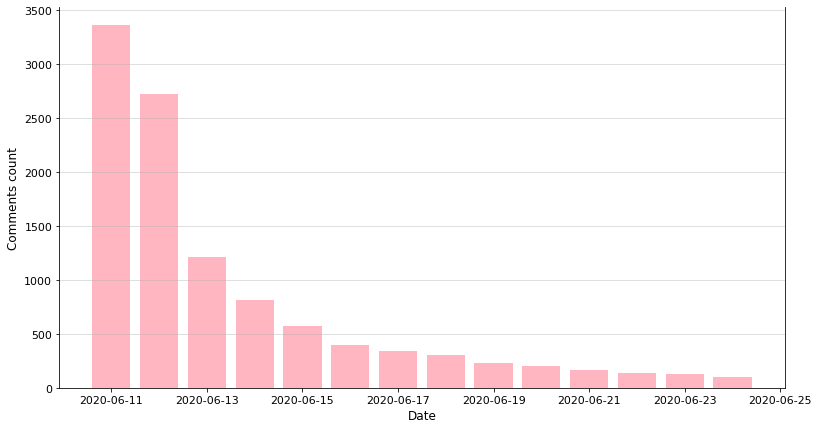

In [57]:
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(13, 7))

axarr.bar(daily_comment_nb_df.index, daily_comment_nb_df.comments_count, color='lightpink')

axarr.tick_params(labelsize=11)
axarr.set_xlabel('Date', size=12)
axarr.set_ylabel('Comments count', size=12)
axarr.grid(axis='y', which='major', alpha=0.5)
axarr.spines['top'].set_visible(False)

# plt.savefig('daily_comments_count.png', bbox_inches='tight')

### Comments during 24 hours after release

In [22]:
comments_df['comment_updatedAt'].min()

'2020-06-11T16:00:12Z'

In [23]:
comments_24h_df = comments_df[comments_df['comment_updatedAt'] <= '2020-06-12T16:00:00Z']

In [24]:
comments_24h_df['comment_update_min'] = comments_24h_df.apply(
    lambda row: datetime(row['comment_updateDate'].year, row['comment_updateDate'].month,
                         row['comment_updateDate'].day, row['comment_updateTime'].hour,
                         row['comment_updateTime'].minute // 5 * 5, 0), axis='columns')


/usr/local/Cellar/ipython/7.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [25]:
nbcomments_5mins = comments_24h_df.groupby(['comment_update_min'])['id'].nunique().to_frame()
nbcomments_5mins = nbcomments_5mins.rename(columns={'id':'nbComments'})


In [26]:
nbcomments_5mins.head()

,nbComments
comment_update_min,
2020-06-11 16:00:00,383
2020-06-11 16:05:00,267
2020-06-11 16:10:00,213
2020-06-11 16:15:00,171
2020-06-11 16:20:00,132


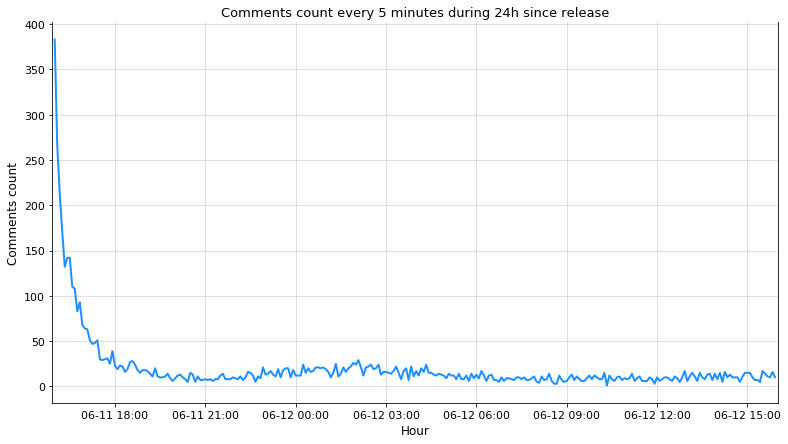

In [56]:
import matplotlib.dates as mdates
hours = mdates.HourLocator(interval=3)
h_fmt = mdates.DateFormatter('%m-%d %H:%M')

fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(13, 7))

axarr.set_title('Comments count every 5 minutes during 24h since release', fontdict={'fontsize': 13})
axarr.plot(nbcomments_5mins.index, nbcomments_5mins.nbComments, color='dodgerblue', lw=2)

axarr.tick_params(labelsize=11)
axarr.set_xlabel('Hour', size=12)
axarr.set_ylabel('Comments count', size=12)
axarr.set_xlim(datetime(2020, 6, 11, 15, 55, 0), datetime(2020, 6, 12, 16, 0, 0))
axarr.xaxis.set_major_locator(hours)
axarr.xaxis.set_major_formatter(h_fmt)

axarr.grid(which='major', alpha=0.5)
axarr.spines['top'].set_visible(False)

# plt.savefig('first24h_comments_count.png', bbox_inches='tight')

### Words cloud

In [28]:
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from langdetect import detect
import string

from PIL import Image
from wordcloud import WordCloud

In [29]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/jingwen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jingwen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
comments_light_df = comments_df.dropna(subset=['comment_VO'])[['id', 'comment_updatedAt', 'comment_updateDate',
                                                               'comment_updateTime', 'comment_VO']]
comments_light_df = comments_light_df[comments_light_df['id'].isin(
    ['UgzBVuAEy5RHo8_qPTB4AaABAg', 'UgwAeC9F_N4vKYKk4UZ4AaABAg',
     'UgwzTW8SMCaJCsRONfB4AaABAg', 'Ugyb_zzwLtRxOlw3hTZ4AaABAg'])==False]


In [31]:
def detect_lang(s):
    try:
        lang = detect(s)
    except:
        lang = 'Cannot be detected.'
    return lang

In [32]:
comments_light_df['lang'] = comments_light_df['comment_VO'].apply(lambda x: detect_lang(x))
comments_light_df.loc[((comments_light_df['lang'] == 'id') &
                       (comments_light_df['comment_updateDate'] == date(2020, 6, 11)) &
                       (comments_light_df['comment_updateTime'] <= time(22, 51, 35))), 'lang'] = 'zh-cn'


In [33]:
comments_light_df.lang.unique()

array(['en', 'zh-tw', 'pt', 'zh-cn', 'Cannot be detected.', 'ko', 'ja',
       'af', 'no', 'et', 'vi', 'es', 'hr', 'ca', 'sw', 'fi', 'pl', 'lt',
       'id', 'sl', 'so', 'sk', 'cy', 'tl', 'it', 'fr', 'cs', 'de', 'ro',
       'sq', 'tr', 'nl', 'da', 'th', 'ru', 'sv', 'ar', 'uk', 'el', 'fa',
       'hu'], dtype=object)

In [ ]:
comments_light_df[comments_light_df['id']=='UgwAeC9F_N4vKYKk4UZ4AaABAg']['comment_VO']

In [ ]:
comments_light_df[comments_light_df['lang']=='lt'] # es
# rm: id = UgzBVuAEy5RHo8_qPTB4AaABAg, UgwAeC9F_N4vKYKk4UZ4AaABAg, UgwzTW8SMCaJCsRONfB4AaABAg, Ugyb_zzwLtRxOlw3hTZ4AaABAg


In [35]:
comments_cn_df = comments_light_df[comments_light_df['lang'].isin(['zh-cn', 'ko', 'zh-tw', 'lt'])]
comments_not_cn_df = comments_light_df[comments_light_df['lang'].isin(['zh-cn', 'ko', 'zh-tw', 'lt'])==False]

In [36]:
sw_en = stopwords.words('english')
sw_fr = stopwords.words('french')

# https://github.com/stopwords-iso/stopwords-zh/blob/master/stopwords-zh.txt
stop_words = sw_en + sw_fr + ['https', 'http', 'youtube', 'com', 'com watch', 'watch', 'www', 'song', 'and',
                              'it', 'the', 'youtu', 'be', 'thi', 'insta', 'akbarfit', '而我的咖啡', '糖不用太多',
                              '麻烦给我的爱人来一杯Mojito', '铁铸的招牌', '错落着就像', '一封封城市', '献给天空的情书',
                              '当街灯亮起', '當街燈亮起', 'Havana漫步', 'havana漫步', '这是世上最美丽的那双人舞',
                              '这世界已经因为她甜得过头', ' ', '，', '。', ' ，', ' 。', '“', '”', '!', '！', '？',
                              ' ？', '?', ':', '/', ' _', ' ！', '~', '[', '!', '"', '一', '\n', '......', 'v',
                              'V', '=', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '～', '✝', '(', ')',
                              '.....', '@', '《', '》', '-', '哈利', 'Dt4IBR3HRQI', '神仙', 'be', '.', 'UwxatzcYf9Q',
                              ']', '这首歌', '這首歌', '都', '那', '那个', '阿弥陀佛', '虽', '虽然', '致', '自', '的',
                              '一直', '一首', '周杰伦', '杰伦', '周杰倫', '杰倫', '一个', '这个', '一些', '一', '一转眼',
                              '不仅', '好好', '只有', '还是', '還是', '且', '这么', '为什么', '么', '也', '了', '得', '地',
                              '着', '二', '于', '在', '些', '们', '呢', '啊', '呀', '人', '们', '任', '在', '会', '你',
                              '我', '他', '她', '它', '我们', '你们', '他们', '她们', '它们', '大家', '俺', '俺们', '儿',
                              '哈哈哈哈', 'watch', 'bXu', 'nnjrvz8', '路亚', 'UKeGPLFG0U4', '升天', '2fdJFVTSEOo',
                              '驾鶴', 'oy6gjGKqNC8', 'i5QO', 'PqL7z8', 'u3000', '\u3000', '1q2AEYpBbG0',
                              'linw3357', '2020', '2021', '2022', '2023', '2024', '2025', '22751731', '0930358081',
                              'line', 'Z2wkX70kDAw', '李老師', '\r\n', '02', '上西天', '就是', '真的']


**only cn comments**

In [37]:
# https://github.com/fxsjy/jieba
import jieba
# jieba.enable_paddle()

In [38]:
cn_comments = ''

for c in comments_cn_df['comment_VO']:
    cn_comments += (c + ' ')

In [39]:
my_words = ['周蕫', '結婚後', '美少女戰士', '主題曲', '慵懶曲調', '麻烦给我的爱人来一杯Mojito', '麻烦给我的爱人来一杯mojito',
            '麻烦给我的爱人来一杯', '铁铸的招牌', '错落着就像', '一封封城市', '献给天空的情书', '当街灯亮起', '當街燈亮起',
            'Havana漫步', 'havana漫步', '这是世上最美丽的那双人舞', '这世界已经因为她甜得过头', '牛逼', '90後', '这首歌', '這首歌']
for i in my_words:
    jieba.add_word(i)

word_num = jieba.lcut(cn_comments, cut_all=False)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/62/8ln5x4ps1h1f3nnpr09mxpzw0000gn/T/jieba.cache
Loading model cost 1.350 seconds.
Prefix dict has been built successfully.


In [40]:
cn_txt = ''
for t in word_num:
    if not t in stop_words:
        cn_txt += (t + ' ')

In [ ]:
# cn_txt

In [41]:
# https://www.google.fr/search?q=chat+logo+white+background&tbm=isch&ved=2ahUKEwiShIu9kZrqAhUB_BoKHZxkCZsQ2-cCegQIABAA&oq=chat+logo+white+background&gs_lcp=CgNpbWcQAzoECAAQEzoICAAQBxAeEBM6BggAEAcQHjoICAAQBxAFEB46CAgAEAgQBxAeUL_EQFifykBg5s5AaABwAHgAgAFHiAH1AZIBATSYAQCgAQGqAQtnd3Mtd2l6LWltZw&sclient=img&ei=oRzzXtKvLIH4a5zJpdgJ&bih=826&biw=1440#imgrc=femkTVmL6Y9ooM
comments_mask = np.array(Image.open('chat_logo.jpg'))


In [42]:
wordcloud_cn = WordCloud(font_path='/Library/Fonts/simhei.ttf',
                          width=1280, height=1280, margin=0,
                          stopwords=stop_words,
                                  colormap='autumn', #'Oranges',
                                  max_words=100000000,
                                  mask=comments_mask).generate(cn_txt)

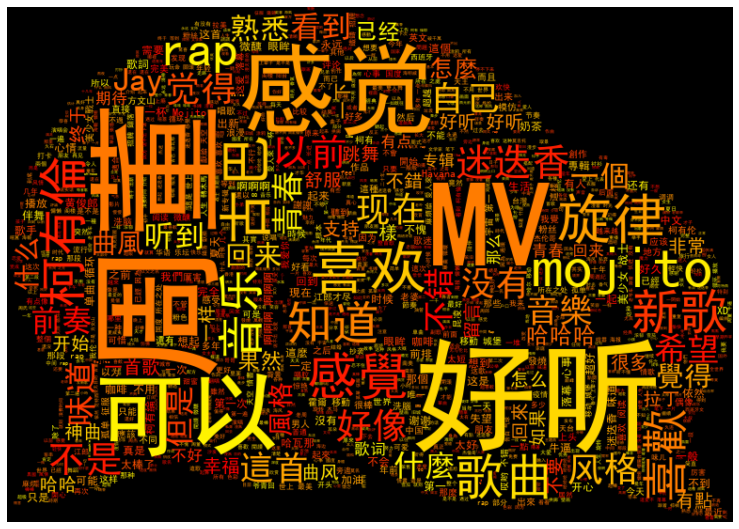

In [55]:
plt.figure(figsize=(13, 13))
plt.imshow(wordcloud_cn, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)

# plt.savefig('comments_cn.png', bbox_inches='tight')

**not cn comments**

In [ ]:
# not_cn_comments = ''

# for c in comments_not_cn_df['comment_VO']:
#     not_cn_comments += (c + ' ')

In [44]:
not_cn_text = ' '.join(comments_not_cn_df['comment_VO'].values).lower()

not_cn_txt_tokens = word_tokenize(not_cn_text, 'english')
not_cn_txt_tokens = list(filter(lambda token: token not in string.punctuation, not_cn_txt_tokens))
not_cn_txt_tokens = list(filter(lambda token: token not in stop_words, not_cn_txt_tokens))

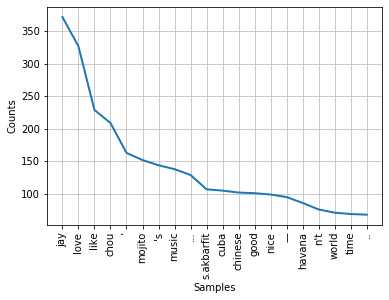

In [45]:
freq_not_cn_txt_tokens = nltk.FreqDist(not_cn_txt_tokens)
freq_not_cn_txt_tokens.plot(20, cumulative=False)

In [46]:
not_cn_txt = nltk.Text(not_cn_txt_tokens)

In [47]:
bigram_finder = nltk.collocations.BigramCollocationFinder.from_words(not_cn_txt_tokens)
trigram_finder = nltk.collocations.TrigramCollocationFinder.from_words(not_cn_txt_tokens)
quadgram_finder = nltk.collocations.QuadgramCollocationFinder.from_words(not_cn_txt_tokens)

bigrams = sorted(bigram_finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))
trigrams = sorted(trigram_finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))
quadgrams = sorted(quadgram_finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))

df_bigrams = pd.DataFrame({' '.join(l[0]):l[1] for l in bigrams}, index=['count']).T
df_trigrams = pd.DataFrame({' '.join(l[0]):l[1] for l in trigrams}, index=['count']).T
df_quadgrams = pd.DataFrame({' '.join(l[0]):l[1] for l in quadgrams}, index=['count']).T


In [48]:
bigrams_txt = ''
for txt, cnt in df_bigrams.iterrows():
    bigrams_txt += (txt + ' ') * int(cnt)


trigrams_txt = ''
for txt, cnt in df_trigrams.iterrows():
    trigrams_txt += (txt + ' ') * int(cnt)


quadgrams_txt = ''
for txt, cnt in df_quadgrams.iterrows():
    quadgrams_txt += (txt + ' ') * int(cnt)


In [49]:
# https://www.google.fr/search?q=jay+chou+logo&tbm=isch&ved=2ahUKEwjDpZ2tjJrqAhWUwoUKHRxPC0QQ2-cCegQIABAA&oq=jay+chou+logo&gs_lcp=CgNpbWcQAzIECAAQE1Ck0whYjtYIYN_XCGgAcAB4AIABwAGIAdACkgEDMy4xmAEAoAEBqgELZ3dzLXdpei1pbWc&sclient=img&ei=QhfzXsP8EZSFlwScnq2gBA&bih=826&biw=1440#imgrc=e5qmK-0-nr-vMM&imgdii=4p_FGFC0_sCI8M
jay_mask = np.array(Image.open('jay_logo.jpg'))


In [50]:
wordcloud_3type_grams = WordCloud(font_path='/Library/Fonts/simhei.ttf',
                                  width=1280, height=1280, margin=0,
                                  colormap='spring', #'Oranges',
                                  stopwords=stop_words,
                                  max_words=100000000,
                                  mask=jay_mask).generate(bigrams_txt + trigrams_txt + quadgrams_txt)

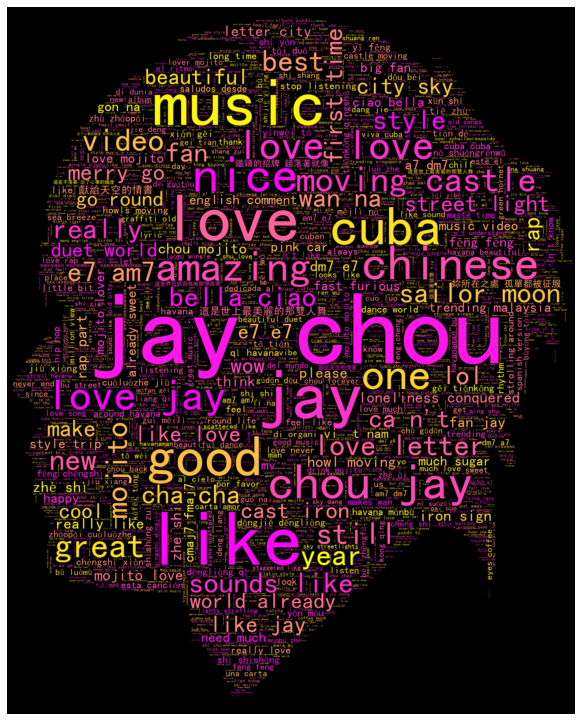

In [58]:
plt.figure(figsize=(13, 13))
plt.imshow(wordcloud_3type_grams, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)

# plt.savefig('comments_not_cn.png', bbox_inches='tight')

**all comments**

In [52]:
# https://static4.depositphotos.com/1004221/347/i/950/depositphotos_3479588-stock-photo-mojito-cocktail-on-white-background.jpg
mojito_mask = np.array(Image.open('mojito_logo.jpg'))

In [53]:
wordcloud_all = WordCloud(font_path='/Library/Fonts/simhei.ttf',
                          width=1280, height=1280, margin=0,
                          stopwords=stop_words,
                          colormap='summer',
#                           background_color='white',
#                           contour_width=1,
#                           contour_color='green',
                          max_words=100000000,
                          mask=mojito_mask).generate(cn_txt + bigrams_txt + trigrams_txt + quadgrams_txt)

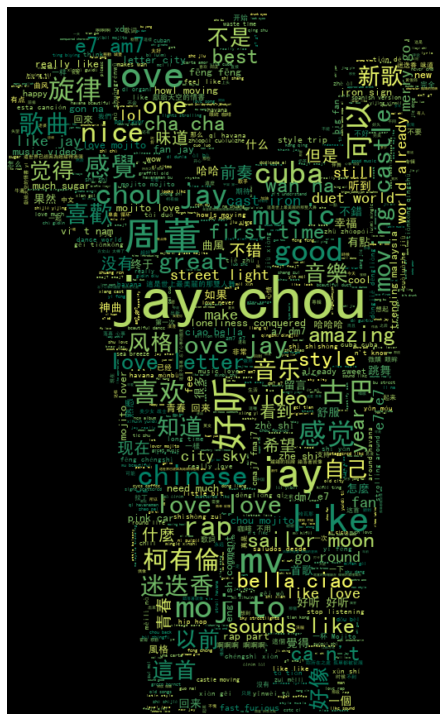

In [59]:
plt.figure(figsize=(13, 13))
plt.imshow(wordcloud_all, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)

# plt.savefig('comments_all.png', bbox_inches='tight')